# plotting functions of figure 3 in the manuscript


In [17]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mrcfile
import gemmi

from tqdm import tqdm

from emmer.pdb.convert.convert_pdb_to_map import convert_pdb_to_map
from emmer.ndimage.filter.low_pass_filter import low_pass_filter

# roodmus
from roodmus.analysis.utils import load_data


In [40]:
# functions
def get_precision_per_class(df_truth, df_picked, classification_job):
    result = {
        "class": [],
        "precision": [],
        "number_of_particles": [],
        "picked_fraction": [],
        "fraction_of_true_positives": [],
    }


    num_gt_particles = len(df_truth)
    df_picked_grouped = df_picked.groupby("jobtype").get_group(classification_job).groupby("class2D")
    num_gt_particles_in_picked = len(df_picked.groupby("jobtype").get_group(classification_job).query("TP == True"))
    print(f"number of particles in ground truth: {num_gt_particles}")
    print(f"number of particles in picked: {num_gt_particles_in_picked}")
    num_picked_particles = len(df_picked.groupby("jobtype").get_group(classification_job))
    for class2d in df_picked_grouped.groups:
        particles_in_class = len(df_picked_grouped.get_group(class2d))
        print(f"number of picked particles in class {class2d}: {particles_in_class}. Fraction of picked particles: {np.round(particles_in_class / num_picked_particles, 2)}")
        TP_in_class = len(df_picked_grouped.get_group(class2d).query("TP == True"))
        precision_in_class = TP_in_class / particles_in_class
        print(f"precision in class {class2d}: {np.round(precision_in_class, 2)}")
        print(f"TP fraction in class: {np.round(TP_in_class / num_gt_particles_in_picked, 2)}")
        print(f"test: {np.round((TP_in_class/num_gt_particles_in_picked) / (particles_in_class/num_picked_particles), 2)}")

        result["class"].append(int(class2d))
        result["precision"].append(precision_in_class)
        result["number_of_particles"].append(particles_in_class)
        result["picked_fraction"].append(particles_in_class / num_picked_particles)
        result["fraction_of_true_positives"].append(TP_in_class / num_gt_particles_in_picked)

    df_result = pd.DataFrame(result)
    return df_result

def compute_correlation(modelmap, targetmap, mask, resolution=2.5, vsize=1):
    """Compute the correlation between two maps"""
    
    warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in scalar divide")
    # apply mask to both maps
    modelmap_filtered = low_pass_filter(modelmap, resolution, vsize)
    modelmap_masked = modelmap_filtered * mask
    targetmap_masked = targetmap * mask
    # compute the mean of the two maps
    mean_modelmap = np.mean(modelmap_masked)
    mean_targetmap = np.mean(targetmap_masked)
    # compute the standard deviation of the two maps
    std_modelmap = np.std(modelmap_masked)
    std_targetmap = np.std(targetmap_masked)
    # compute the correlation
    correlation = np.mean((modelmap_masked - mean_modelmap) * (targetmap_masked - mean_targetmap)) / (std_modelmap * std_targetmap)
    return correlation

def filter_gemmi_model(model_gemmi, remove_sidechains=False):
    # remove ligand residues and all sidechain atoms
    list_of_residue_names = [
        "F2A", "H2A", "NLM", "NM5", "NM7", "NME"
    ]
    new_model_gemmi = gemmi.Model(model_gemmi.name)
    for chn in model_gemmi:
        new_chain_gemmi = gemmi.Chain(chn.name)
        for res in chn:
            if res.name not in list_of_residue_names:
                new_res_gemmi = gemmi.Residue()
                new_res_gemmi.name = res.name
                
                if remove_sidechains:
                    for atm in res:
                        if atm.name == "CA":
                            new_atm_gemmi = gemmi.Atom()
                            new_atm_gemmi.name = atm.name
                            new_atm_gemmi.pos = atm.pos
                            new_atm_gemmi.element = gemmi.Element(atm.element.name)
                            new_res_gemmi.add_atom(new_atm_gemmi)

                else:
                    for atm in res:
                        new_atm_gemmi = gemmi.Atom()
                        new_atm_gemmi.name = atm.name
                        new_atm_gemmi.pos = atm.pos
                        new_atm_gemmi.element = gemmi.Element(atm.element.name)
                        new_res_gemmi.add_atom(new_atm_gemmi)                  

                new_chain_gemmi.add_residue(new_res_gemmi)
        new_model_gemmi.add_chain(new_chain_gemmi)
    return new_model_gemmi

def get_modelmap_stack(ensemble_open_gemmi, ensemble_closed_gemmi, unitcell, size):
    modelmaps_open = []
    for frame_model in tqdm(ensemble_open_gemmi):
        frame_gemmi = gemmi.Structure()
        filtered_frame_model = filter_gemmi_model(frame_model)
        frame_gemmi.add_model(filtered_frame_model)
        map_from_model_zyx = convert_pdb_to_map(
            input_pdb=frame_gemmi,
            unitcell=unitcell,
            size=size,
            return_grid=False,
        )
        # map_from_model_zyx = low_pass_filter(
        #     map_from_model_unfiltered, resolution, vsize
        # )
        map_from_model = np.rot90(
            np.flip(map_from_model_zyx, axis=0), axes=(2, 0)
        )
        modelmaps_open.append(map_from_model)

    modelmaps_closed = []
    for frame_model in tqdm(ensemble_closed_gemmi):
        frame_gemmi = gemmi.Structure()
        frame_gemmi.add_model(frame_model)
        map_from_model_zyx = convert_pdb_to_map(
            input_pdb=frame_gemmi,
            unitcell=unitcell,
            size=size,
            return_grid=False,
        )
        # map_from_model_zyx = low_pass_filter(
        #     map_from_model_unfiltered, resolution, vsize
        # )
        map_from_model = np.rot90(
            np.flip(map_from_model_zyx, axis=0), axes=(2, 0)
        )
        modelmaps_closed.append(map_from_model)
    return modelmaps_open, modelmaps_closed

In [ ]:
### data loading
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed"
config_dir = os.path.join(project_dir, "Micrographs")
meta_files = [
    # os.path.join(project_dir, "Extract", "job004", "particles.star"),
    # os.path.join(project_dir, "Extract", "job009", "particles.star"),
    # os.path.join(project_dir, "Select", "job012", "particles.star"),
    os.path.join(project_dir, "Class3D", "job014", "run_it025_data.star"),
    os.path.join(project_dir, "Class3D", "job037", "run_it025_data.star"),
    os.path.join(project_dir, "Class3D", "job038", "run_it025_data.star"),
]

jobtypes = {
    os.path.join(project_dir, "Extract", "job004", "particles.star"): "LoG",
    os.path.join(project_dir, "Extract", "job009", "particles.star"): "topaz",
    os.path.join(project_dir, "Select", "job012", "particles.star"): "class selection",
    os.path.join(project_dir, "Class3D", "job014", "run_it025_data.star"): "3_classes",
    os.path.join(project_dir, "Class3D", "job037", "run_it025_data.star"): "2_classes",
    os.path.join(project_dir, "Class3D", "job038", "run_it025_data.star"): "10_classes",
}

particle_diameter = 100 # approximate particle diameter in Angstroms
ugraph_shape = (4000, 4000) # shape of the micrograph in pixels. Only needs to be given if the metadata file is a .star file
verbose = True # prints out progress statements
ignore_missing_files = True # if .mrc files are missing, the analysis will still be performed
enable_tqdm = True # enables tqdm progress bars

for i, meta_file in enumerate(meta_files):
    if i == 0:
        analysis = load_data(meta_file, config_dir, particle_diameter, ugraph_shape=ugraph_shape, verbose=verbose, enable_tqdm=enable_tqdm, ignore_missing_files=ignore_missing_files) # creates the class
    else:
        analysis.add_data(meta_file, config_dir, verbose=verbose) # updates the class with the next metadata file

df_picked = pd.DataFrame(analysis.results_picking)
df_truth = pd.DataFrame(analysis.results_truth)
df_precision, df_picked = analysis.compute_precision(df_picked, df_truth, verbose=verbose)
df_picked["jobtype"] = df_picked["metadata_filename"].map(jobtypes)
df_picked_grouped = df_picked.groupby("jobtype")
for group in df_picked_grouped.groups:
    print(f"jobtype: {group}, number of particles: {len(df_picked_grouped.get_group(group))}")

df_precision["jobtype"] = df_precision["metadata_filename"].map(jobtypes)
df_truth["pdb_index"] = df_truth["pdb_filename"].apply(lambda x: int(x.strip(".pdb").split("_")[-1]))

## panel A
for the 3D classification dataset with 2 classes:

plot of the distribution of frames from the MD trajectory over each class\
plot of the precision of picked particles in each class\
plot of the fraction of particles in each class\
plot correlating the class density maps to a sampling of frames from the MD trajectory

number of TP particles in 2_classes: 98329


/tmp/ipykernel_5634/3979232313.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_picked_grouped["state"] = df_picked_grouped["closest_pdb_index"] <= 8334
/tmp/ipykernel_5634/3979232313.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_picked_grouped["state"] = df_picked_grouped["state"].map({True: "closed", False: "open"})
/tmp/ipykernel_5634/3979232313.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

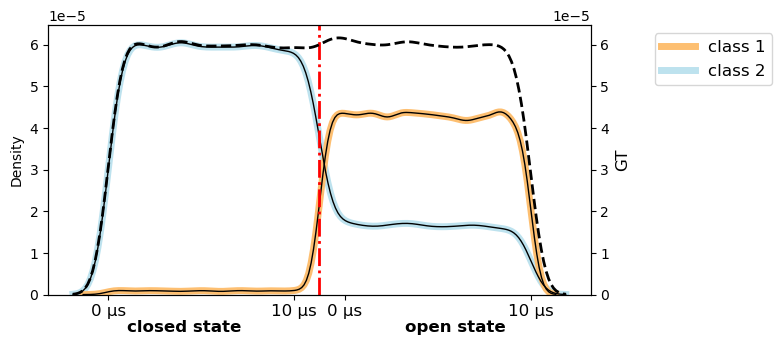

In [12]:
# add a column to the df_picked data frame that indicates if the particles originates from the open or closed state of the spike protein
classification_job = "2_classes"

df_truth["pdb_index"] = df_truth["pdb_filename"].apply(lambda x: int(x.strip(".pdb").split("_")[-1]))
df_picked_grouped = df_picked.groupby(["jobtype", "TP"]).get_group((classification_job,True))
print(f"number of TP particles in {classification_job}: {len(df_picked_grouped)}")
# if the closest_pdb_index < 8334, the particle originates from the closed state, otherwise it originates from the open state
df_picked_grouped["state"] = df_picked_grouped["closest_pdb_index"] <= 8334
df_picked_grouped["state"] = df_picked_grouped["state"].map({True: "closed", False: "open"})
# df_picked_grouped["class2D"] = df_picked_grouped["class2D"].astype(int)
df_picked_grouped.sort_values(by="class2D", inplace=True)
num_classes = len(df_picked_grouped.groupby("class2D").groups)

fig, ax = plt.subplots(figsize=(7, 3.5))
# make kde plot out of the data
kde_picked = sns.kdeplot(
    data=df_picked_grouped,
    x="closest_pdb_index",
    ax=ax,
    hue="class2D",
    fill=False,
    label="class2D",
    linewidth=5,
    alpha=1,
    palette="RdYlBu",
    legend=True,
)
# add an extra black line over the second class
kde_extra = sns.kdeplot(
    data=df_picked_grouped,
    x="closest_pdb_index",
    ax=ax,
    hue="class2D",
    palette={f"{r+1}":"black" for r in range(num_classes)},
    label="picked_particles",
    linewidth=1,
    alpha=1,
    fill=False,
    legend=False,
)
# add kdeplot of the True particles
ax_truth = ax.twinx()
kde_truth = sns.kdeplot(
    data=df_truth,
    x="pdb_index",
    ax=ax_truth,
    color="black",
    linestyle="--",
    label="GT",
    linewidth=2,
    fill=False,
    alpha=1,
    legend=True,
)

# get the legend handles from kde_picked
handles, labels = ax.get_legend_handles_labels()
h = [handles[r] for r in range(len(handles)) if labels[r] == "class2D"]
h = h[::-1]
h.extend([handles[r] for r in range(len(handles)) if labels[r] == "GT"])
l = [f"class {r+1}" for r in range(num_classes)] + ["GT"]
# add the legend
ax.legend(
    handles=h,
    labels=l,
    loc='upper right',
    bbox_to_anchor=(1.35, 1.0),
    ncol=1,
    fontsize=12,
    frameon=True,
)
ax_truth.set_ylabel("GT", fontsize=12)
if num_classes == 10:
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[1]*1.1)
else:
    ylim = ax_truth.get_ylim()
    ax.set_ylim(ylim[0], ylim[1])

# change the xticks to the time in us
ax.set_xticks([0, 8334-1000, 8334+1000, 16668])
ax.set_xticklabels(["0 \u03BCs", "10 \u03BCs", "0 \u03BCs", "10 \u03BCs"], fontsize=12)
ax.axvline(x=8334, color="red", linestyle="-.", linewidth=2)
ax.set_xlabel("")
# label the right side of the plot with 'open state' and the left side with 'closed state' undeneath the x-axis
ax.text(0.25, -0.15, "closed state", ha='center', va='bottom', fontsize=12, fontweight='bold', transform=ax.transAxes)
ax.text(0.75, -0.15, "open state", ha='center', va='bottom', fontsize=12, fontweight='bold', transform=ax.transAxes)

# save the figure
fig.savefig(os.path.join(project_dir, "figures", f"frame_distribution_{classification_job}.pdf"), bbox_inches="tight")


number of particles in ground truth: 120000
number of particles in picked: 98329
number of picked particles in class 1: 36637. Fraction of picked particles: 0.35
precision in class 1: 0.98
TP fraction in class: 0.37
test: 1.05
number of picked particles in class 2: 68829. Fraction of picked particles: 0.65
precision in class 2: 0.91
TP fraction in class: 0.63
test: 0.97


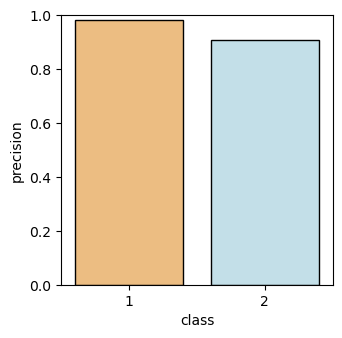

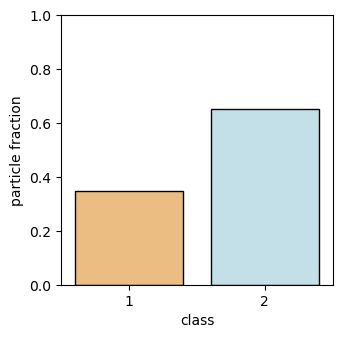

In [15]:
# plot the preicison per 3D class
classification_job = "2_classes"

df_result = get_precision_per_class(df_truth, df_picked, classification_job)
# setup colors
num_classes = len(df_result["class"].unique())
colors = sns.color_palette("RdYlBu", n_colors=num_classes)

fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.barplot(
    data=df_result,
    x="class",
    y="precision",
    hue="class",
    palette=colors,
    edgecolor='black',
    ax=ax,
    dodge=0,
    linewidth=1,
    gap=0,
)
# remove legend
ax.legend().remove()
ax.set_ylim((0, 1))
fig.savefig(os.path.join(project_dir, "figures", f"precision_{classification_job}.pdf"), bbox_inches="tight")

fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.barplot(
    data=df_result,
    x="class",
    y="picked_fraction",
    hue="class",
    palette=colors,
    edgecolor='black',
    ax=ax,
    dodge=0,
    linewidth=1,
    gap=0,
)
# remove legend
ax.legend().remove()
ax.set_ylabel("particle fraction")
ax.set_ylim((0, 1))
fig.savefig(os.path.join(project_dir, "figures", f"particle_fraction_{classification_job}.pdf"), bbox_inches="tight")


100%|██████████| 25/25 [06:48<00:00, 16.32s/it]


0.1970228915317667


Text(-0.65, 12, 'open state')

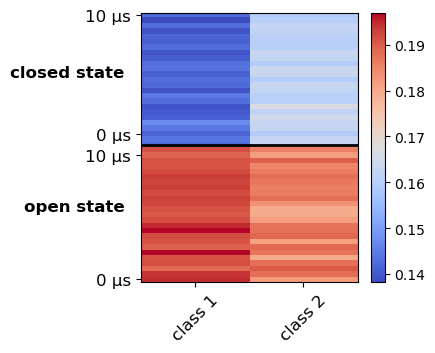

In [41]:
# computing and plotting the correlation matrix between 3D classes and frames from the MD trajectory
# before running this cell, an ensemble structure should be created from the MD trajecgory of K frames
# this ensemble structure needs to be aligned to the 3D classes (which should all be in the same orientation too)
# a modelmask is also needed that covers the entire ensemble. I made this using the molmap command in ChimeraX, and then thresholding it at 2 standard deviations below the mean

# procedure:
# load the ensembles, compute a model-map for each frame in the ensemble
# load the class maps,
# mask the model-maps and the class maps
# compute the correlation between the masked model-maps and the masked class maps

# inputs and parameters
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed"
open_ensemble = os.path.join(project_dir, "aligned_ensembles", "ensemble_open_job018.pdb")
closed_ensemble = os.path.join(project_dir, "aligned_ensembles", "ensemble_closed_job018.pdb")
open_mask = os.path.join(project_dir, "aligned_ensembles", "ensemble_open_job018_mask.mrc")
closed_mask = os.path.join(project_dir, "aligned_ensembles", "ensemble_closed_job018_mask.mrc")

# 2 class data set
classes_data = {
    "class1": {
        "job": "job044",
        "map": "run_class001.mrc",
        "resolution": 2.46,
    },
    "class2": {
        "job": "job050",
        "map": "run_class001.mrc",
        "resolution": 2.41,
    },
}
n_classes = len(classes_data)

# load the class maps
for class_name, class_data in classes_data.items():
    class_map = os.path.join(project_dir, "Refine3D", class_data["job"], class_data["map"])
    classes_data[class_name]["map_data"] = mrcfile.open(class_map).data

# get the gemmi structure of the first class
class1_gemmi = gemmi.read_ccp4_map(os.path.join(project_dir, "Refine3D", classes_data["class1"]["job"], classes_data["class1"]["map"]))
unitcell = class1_gemmi.grid.unit_cell
size = class1_gemmi.grid.shape
vsize = class1_gemmi.grid.spacing[0]

# load the masks
open_mask_mrc = mrcfile.open(open_mask)
closed_mask_mrc = mrcfile.open(closed_mask)

# load the ensembles
ensemble_open_gemmi = gemmi.read_structure(open_ensemble)
ensemble_closed_gemmi = gemmi.read_structure(closed_ensemble)
n_frames = len(ensemble_open_gemmi) + len(ensemble_closed_gemmi)

modelmaps_open, modelmaps_closed = get_modelmap_stack(ensemble_open_gemmi, ensemble_closed_gemmi, unitcell, size)

# compute the correlation
correlation_matrix = np.zeros((n_frames, n_classes))
for i, modelmap in enumerate(tqdm(modelmaps_open)):
    for j, class_name in enumerate(classes_data.keys()):
        correlation_matrix[i, j] = compute_correlation(modelmap, classes_data[class_name]["map_data"], open_mask_mrc.data, classes_data[class_name]["resolution"], vsize)

for i, modelmap in enumerate(tqdm(modelmaps_closed)):
    for j, class_name in enumerate(classes_data.keys()):
        correlation_matrix[i+len(modelmaps_open), j] = compute_correlation(modelmap, classes_data[class_name]["map_data"], closed_mask_mrc.data)
print(correlation_matrix.max())

fig, ax = plt.subplots(figsize=(3.5, 3.5))
# show the heatmap as a square (~50x3)
ax.imshow(correlation_matrix, cmap="coolwarm", aspect="auto", origin="lower")
ticklabels = [f"class {i+1}" for i in range(n_classes)]
ax.set_xticks(range(n_classes))
ax.set_xticklabels(ticklabels, fontsize=12, rotation=45)
ax.set_yticks([0, n_frames//2-2, n_frames//2+2, n_frames-1])
ax.set_yticklabels(["0 \u03BCs", "10 \u03BCs", "0 \u03BCs", "10 \u03BCs"], fontsize=12)
ax.axhline(y=n_frames//2, color="black", linestyle="solid", linewidth=2)
# add colorbar
cbar = ax.figure.colorbar(ax.get_images()[0], ax=ax, orientation="vertical")
ax.text(
    -0.65,
    3*n_frames//4,
    "closed state",
    ha='right',
    va='bottom',
    fontsize=12,
    fontweight='bold',
)
ax.text(
    -0.65,
    n_frames//4,
    "open state",
    ha='right',
    va='bottom',
    fontsize=12,
    fontweight='bold',
)

# save the figure
# fig.savefig(os.path.join(project_dir, "figures", f"correlation_matrix_{n_classes}classes.pdf"), bbox_inches="tight")    

## panel B
for the 3D classification dataset with 3 classes:

plot of the distribution of frames from the MD trajectory over each class\
plot of the precision of picked particles in each class\
plot of the fraction of particles in each class\
plot correlating the class density maps to a sampling of frames from the MD trajectory

number of TP particles in 3_classes: 98329


/tmp/ipykernel_5634/240432667.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_picked_grouped["state"] = df_picked_grouped["closest_pdb_index"] <= 8334
/tmp/ipykernel_5634/240432667.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_picked_grouped["state"] = df_picked_grouped["state"].map({True: "closed", False: "open"})
/tmp/ipykernel_5634/240432667.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

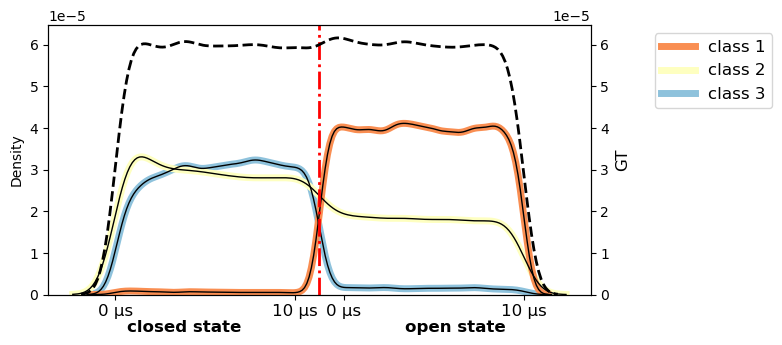

In [10]:
# add a column to the df_picked data frame that indicates if the particles originates from the open or closed state of the spike protein
classification_job = "3_classes"

df_truth["pdb_index"] = df_truth["pdb_filename"].apply(lambda x: int(x.strip(".pdb").split("_")[-1]))
df_picked_grouped = df_picked.groupby(["jobtype", "TP"]).get_group((classification_job,True))
print(f"number of TP particles in {classification_job}: {len(df_picked_grouped)}")
# if the closest_pdb_index < 8334, the particle originates from the closed state, otherwise it originates from the open state
df_picked_grouped["state"] = df_picked_grouped["closest_pdb_index"] <= 8334
df_picked_grouped["state"] = df_picked_grouped["state"].map({True: "closed", False: "open"})
# df_picked_grouped["class2D"] = df_picked_grouped["class2D"].astype(int)
df_picked_grouped.sort_values(by="class2D", inplace=True)
num_classes = len(df_picked_grouped.groupby("class2D").groups)

fig, ax = plt.subplots(figsize=(7, 3.5))
# make kde plot out of the data
kde_picked = sns.kdeplot(
    data=df_picked_grouped,
    x="closest_pdb_index",
    ax=ax,
    hue="class2D",
    fill=False,
    label="class2D",
    linewidth=5,
    alpha=1,
    palette="RdYlBu",
    legend=True,
)
# add an extra black line over the second class
kde_extra = sns.kdeplot(
    data=df_picked_grouped,
    x="closest_pdb_index",
    ax=ax,
    hue="class2D",
    palette={f"{r+1}":"black" for r in range(num_classes)},
    label="picked_particles",
    linewidth=1,
    alpha=1,
    fill=False,
    legend=False,
)
# add kdeplot of the True particles
ax_truth = ax.twinx()
kde_truth = sns.kdeplot(
    data=df_truth,
    x="pdb_index",
    ax=ax_truth,
    color="black",
    linestyle="--",
    label="GT",
    linewidth=2,
    fill=False,
    alpha=1,
    legend=True,
)

# get the legend handles from kde_picked
handles, labels = ax.get_legend_handles_labels()
h = [handles[r] for r in range(len(handles)) if labels[r] == "class2D"]
h = h[::-1]
h.extend([handles[r] for r in range(len(handles)) if labels[r] == "GT"])
l = [f"class {r+1}" for r in range(num_classes)] + ["GT"]
# add the legend
ax.legend(
    handles=h,
    labels=l,
    loc='upper right',
    bbox_to_anchor=(1.35, 1.0),
    ncol=1,
    fontsize=12,
    frameon=True,
)
ax_truth.set_ylabel("GT", fontsize=12)
if num_classes == 10:
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[1]*1.1)
else:
    ylim = ax_truth.get_ylim()
    ax.set_ylim(ylim[0], ylim[1])

# change the xticks to the time in us
ax.set_xticks([0, 8334-1000, 8334+1000, 16668])
ax.set_xticklabels(["0 \u03BCs", "10 \u03BCs", "0 \u03BCs", "10 \u03BCs"], fontsize=12)
ax.axvline(x=8334, color="red", linestyle="-.", linewidth=2)
ax.set_xlabel("")
# label the right side of the plot with 'open state' and the left side with 'closed state' undeneath the x-axis
ax.text(0.25, -0.15, "closed state", ha='center', va='bottom', fontsize=12, fontweight='bold', transform=ax.transAxes)
ax.text(0.75, -0.15, "open state", ha='center', va='bottom', fontsize=12, fontweight='bold', transform=ax.transAxes)

# save the figure
fig.savefig(os.path.join(project_dir, "figures", f"frame_distribution_{classification_job}.pdf"), bbox_inches="tight")


100%|██████████| 25/25 [06:16<00:00, 15.08s/it]

0.23448617454543852


Text(-0.65, 12, 'open state')

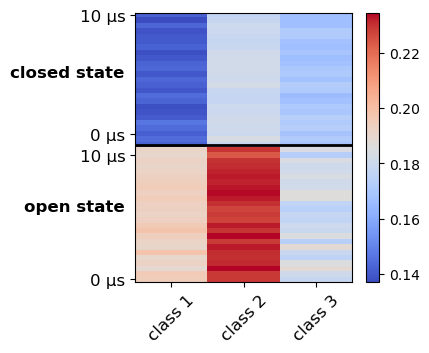

In [42]:

# computing and plotting the correlation matrix between 3D classes and frames from the MD trajectory
# before running this cell, an ensemble structure should be created from the MD trajecgory of K frames
# this ensemble structure needs to be aligned to the 3D classes (which should all be in the same orientation too)
# a modelmask is also needed that covers the entire ensemble. I made this using the molmap command in ChimeraX, and then thresholding it at 2 standard deviations below the mean

# procedure:
# load the ensembles, compute a model-map for each frame in the ensemble
# load the class maps,
# mask the model-maps and the class maps
# compute the correlation between the masked model-maps and the masked class maps

# inputs and parameters
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed"
open_ensemble = os.path.join(project_dir, "aligned_ensembles", "ensemble_open_job018.pdb")
closed_ensemble = os.path.join(project_dir, "aligned_ensembles", "ensemble_closed_job018.pdb")
open_mask = os.path.join(project_dir, "aligned_ensembles", "ensemble_open_job018_mask.mrc")
closed_mask = os.path.join(project_dir, "aligned_ensembles", "ensemble_closed_job018_mask.mrc")

# 3 class data set
classes_data = {
    "class1": {
        "job": "job018",
        "map": "run_class001.mrc",
        "resolution": 2.46,
    },
    "class2": {
        "job": "job031",
        "map": "run_class001.mrc",
        "resolution": 3.9,
    },
    "class3": {
        "job": "job032",
        "map": "run_class001.mrc",
        "resolution": 2.58
    },
}
n_classes = len(classes_data)

# load the class maps
for class_name, class_data in classes_data.items():
    class_map = os.path.join(project_dir, "Refine3D", class_data["job"], class_data["map"])
    classes_data[class_name]["map_data"] = mrcfile.open(class_map).data

# get the gemmi structure of the first class
class1_gemmi = gemmi.read_ccp4_map(os.path.join(project_dir, "Refine3D", classes_data["class1"]["job"], classes_data["class1"]["map"]))
unitcell = class1_gemmi.grid.unit_cell
size = class1_gemmi.grid.shape
vsize = class1_gemmi.grid.spacing[0]

# load the masks
open_mask_mrc = mrcfile.open(open_mask)
closed_mask_mrc = mrcfile.open(closed_mask)

# load the ensembles
ensemble_open_gemmi = gemmi.read_structure(open_ensemble)
ensemble_closed_gemmi = gemmi.read_structure(closed_ensemble)
n_frames = len(ensemble_open_gemmi) + len(ensemble_closed_gemmi)

modelmaps_open, modelmaps_closed = get_modelmap_stack(ensemble_open_gemmi, ensemble_closed_gemmi, unitcell, size)

# compute the correlation
correlation_matrix = np.zeros((n_frames, n_classes))
for i, modelmap in enumerate(tqdm(modelmaps_open)):
    for j, class_name in enumerate(classes_data.keys()):
        correlation_matrix[i, j] = compute_correlation(modelmap, classes_data[class_name]["map_data"], open_mask_mrc.data, classes_data[class_name]["resolution"], vsize)

for i, modelmap in enumerate(tqdm(modelmaps_closed)):
    for j, class_name in enumerate(classes_data.keys()):
        correlation_matrix[i+len(modelmaps_open), j] = compute_correlation(modelmap, classes_data[class_name]["map_data"], closed_mask_mrc.data)
print(correlation_matrix.max())

fig, ax = plt.subplots(figsize=(3.5, 3.5))
# show the heatmap as a square (~50x3)
ax.imshow(correlation_matrix, cmap="coolwarm", aspect="auto", origin="lower")
ticklabels = [f"class {i+1}" for i in range(n_classes)]
ax.set_xticks(range(n_classes))
ax.set_xticklabels(ticklabels, fontsize=12, rotation=45)
ax.set_yticks([0, n_frames//2-2, n_frames//2+2, n_frames-1])
ax.set_yticklabels(["0 \u03BCs", "10 \u03BCs", "0 \u03BCs", "10 \u03BCs"], fontsize=12)
ax.axhline(y=n_frames//2, color="black", linestyle="solid", linewidth=2)
# add colorbar
cbar = ax.figure.colorbar(ax.get_images()[0], ax=ax, orientation="vertical")
ax.text(
    -0.65,
    3*n_frames//4,
    "closed state",
    ha='right',
    va='bottom',
    fontsize=12,
    fontweight='bold',
)
ax.text(
    -0.65,
    n_frames//4,
    "open state",
    ha='right',
    va='bottom',
    fontsize=12,
    fontweight='bold',
)

# save the figure
# fig.savefig(os.path.join(project_dir, "figures", f"correlation_matrix_{n_classes}classes.pdf"), bbox_inches="tight")    

## panel C
for the 3D classification dataset with 10 classes:

plot of the distribution of frames from the MD trajectory over each class\
plot of the precision of picked particles in each class\
plot of the fraction of particles in each class\
plot correlating the class density maps to a sampling of frames from the MD trajectory

number of TP particles in 10_classes: 98329


/tmp/ipykernel_5634/454379648.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_picked_grouped["state"] = df_picked_grouped["closest_pdb_index"] <= 8334
/tmp/ipykernel_5634/454379648.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_picked_grouped["state"] = df_picked_grouped["state"].map({True: "closed", False: "open"})
/tmp/ipykernel_5634/454379648.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

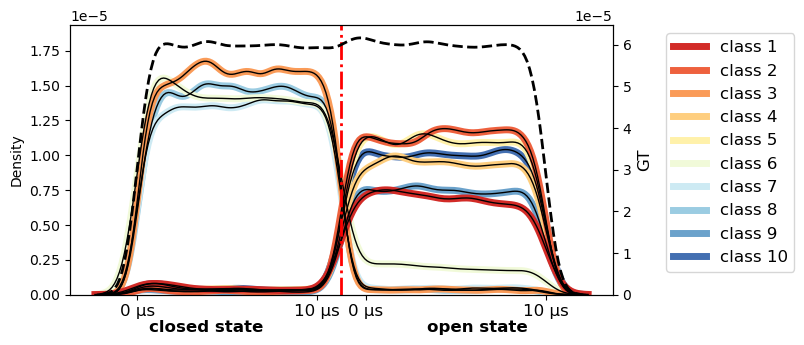

In [11]:
# add a column to the df_picked data frame that indicates if the particles originates from the open or closed state of the spike protein
classification_job = "10_classes"

df_truth["pdb_index"] = df_truth["pdb_filename"].apply(lambda x: int(x.strip(".pdb").split("_")[-1]))
df_picked_grouped = df_picked.groupby(["jobtype", "TP"]).get_group((classification_job,True))
print(f"number of TP particles in {classification_job}: {len(df_picked_grouped)}")
# if the closest_pdb_index < 8334, the particle originates from the closed state, otherwise it originates from the open state
df_picked_grouped["state"] = df_picked_grouped["closest_pdb_index"] <= 8334
df_picked_grouped["state"] = df_picked_grouped["state"].map({True: "closed", False: "open"})
# df_picked_grouped["class2D"] = df_picked_grouped["class2D"].astype(int)
df_picked_grouped.sort_values(by="class2D", inplace=True)
num_classes = len(df_picked_grouped.groupby("class2D").groups)

fig, ax = plt.subplots(figsize=(7, 3.5))
# make kde plot out of the data
kde_picked = sns.kdeplot(
    data=df_picked_grouped,
    x="closest_pdb_index",
    ax=ax,
    hue="class2D",
    fill=False,
    label="class2D",
    linewidth=5,
    alpha=1,
    palette="RdYlBu",
    legend=True,
)
# add an extra black line over the second class
kde_extra = sns.kdeplot(
    data=df_picked_grouped,
    x="closest_pdb_index",
    ax=ax,
    hue="class2D",
    palette={f"{r+1}":"black" for r in range(num_classes)},
    label="picked_particles",
    linewidth=1,
    alpha=1,
    fill=False,
    legend=False,
)
# add kdeplot of the True particles
ax_truth = ax.twinx()
kde_truth = sns.kdeplot(
    data=df_truth,
    x="pdb_index",
    ax=ax_truth,
    color="black",
    linestyle="--",
    label="GT",
    linewidth=2,
    fill=False,
    alpha=1,
    legend=True,
)

# get the legend handles from kde_picked
handles, labels = ax.get_legend_handles_labels()
h = [handles[r] for r in range(len(handles)) if labels[r] == "class2D"]
h = h[::-1]
h.extend([handles[r] for r in range(len(handles)) if labels[r] == "GT"])
l = [f"class {r+1}" for r in range(num_classes)] + ["GT"]
# add the legend
ax.legend(
    handles=h,
    labels=l,
    loc='upper right',
    bbox_to_anchor=(1.35, 1.0),
    ncol=1,
    fontsize=12,
    frameon=True,
)
ax_truth.set_ylabel("GT", fontsize=12)
if num_classes == 10:
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[1]*1.1)
else:
    ylim = ax_truth.get_ylim()
    ax.set_ylim(ylim[0], ylim[1])

# change the xticks to the time in us
ax.set_xticks([0, 8334-1000, 8334+1000, 16668])
ax.set_xticklabels(["0 \u03BCs", "10 \u03BCs", "0 \u03BCs", "10 \u03BCs"], fontsize=12)
ax.axvline(x=8334, color="red", linestyle="-.", linewidth=2)
ax.set_xlabel("")
# label the right side of the plot with 'open state' and the left side with 'closed state' undeneath the x-axis
ax.text(0.25, -0.15, "closed state", ha='center', va='bottom', fontsize=12, fontweight='bold', transform=ax.transAxes)
ax.text(0.75, -0.15, "open state", ha='center', va='bottom', fontsize=12, fontweight='bold', transform=ax.transAxes)

# save the figure
fig.savefig(os.path.join(project_dir, "figures", f"frame_distribution_{classification_job}.pdf"), bbox_inches="tight")
